<a href="https://colab.research.google.com/github/MuhammedAshraf2020/yolo_using_pytorch/blob/main/pretrain/Pretrainipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedashraf2020","key":"cd432666427ed4fad82b3c48c33bb008"}'}

In [ ]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c dogs-vs-cats

 96% 521M/543M [00:04<00:00, 105MB/s]
100% 543M/543M [00:04<00:00, 119MB/s]
 93% 253M/271M [00:02<00:00, 137MB/s]
100% 271M/271M [00:02<00:00, 103MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 88.6MB/s]


In [ ]:
!unzip /content/train.zip

In [2]:
!python annotate_pretrain.py /content/train

25000
17500it [00:47, 371.36it/s]
7500it [00:17, 418.83it/s]


In [5]:
import torch.optim as optim
import torch.nn as nn
import torch
from pretrain_custom import CustomData
from pretrain_model import Yolov1
import torchvision.transforms as transform
from torch.utils.data import DataLoader

epochs = 10
BATCH_SIZE = 100
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


class Compose(object):
	def __init__(self , transforms):
		self.transforms = transforms

	def __call__(self , img):
		for trans in self.transforms:
			img  = trans(img)
		return img

transforms = Compose([transform.Resize((224 , 224)) , transform.ToTensor()])

train_data = CustomData( annotate_file = "train.csv" , transform = transforms)
test_data  = CustomData(annotate_file = "test.csv"  , transform = transforms) 

train_loader = DataLoader(train_data , batch_size = BATCH_SIZE , shuffle = True)
test_loader  = DataLoader(test_data  , batch_size = BATCH_SIZE , shuffle = True)

pretrain_model = Yolov1(3 , S = 7 , B = 2 , C = 20)

pretrain_classifier = nn.Sequential(
				nn.Flatten() ,
				nn.Linear( 25088 * 2, 1024) ,
				nn.ReLU() ,
				nn.Dropout(0.4)  ,
				nn.Linear(1024 , 256) , 
        nn.ReLU() ,
        nn.Linear(256 , 2) ,
        nn.Softmax(1),
	) 

pretrain_model.fcs = pretrain_classifier

loss_fn   = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrain_model.parameters() , lr = LEARNING_RATE)

pretrain_model = pretrain_model.to(DEVICE)

def CalcAccuracy(generator , model):
  num_correct = 0  
  num_samples = 0
  with torch.no_grad():
    for x , y in generator:
      x = x.to(device = "cuda")
      y = y.to(device = "cuda")
      scores = model(x)
      _ , prediction = scores.max(1)
      num_correct += (prediction == y).sum()
      num_samples += prediction.size(0)
  return (num_correct / num_samples) * 100

for epoch in range(epochs):
  for (data , target) in train_loader:
    data   = data.to(DEVICE)
    target = target.to(DEVICE)
    scores = pretrain_model(data)
    loss   = loss_fn(scores , target)
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()
  if epoch % 5 == 0:
    torch.save(pretrain_model.state_dict() , "model.pth")
    print("Model Saved Successfully!")
  train_acc = CalcAccuracy(train_loader , pretrain_model )
  test_acc  = CalcAccuracy(test_loader  , pretrain_model )
  print("Train acc = {:.3f} , test acc = {:.3f}".format(train_acc , test_acc))

Model Saved Successfully!
Train acc = 74.903 , test acc = 73.867
Train acc = 81.217 , test acc = 79.640
Train acc = 84.811 , test acc = 83.333
Train acc = 89.737 , test acc = 86.573
Train acc = 86.731 , test acc = 84.173
Model Saved Successfully!
Train acc = 90.869 , test acc = 87.600
Train acc = 92.286 , test acc = 88.680
Train acc = 93.417 , test acc = 90.160
Train acc = 92.623 , test acc = 89.293
Train acc = 92.709 , test acc = 89.067


In [6]:
torch.save(pretrain_model.state_dict() , "model.pth")

In [40]:
X_test = []
y_test = []

for x , y in test_loader:
  X_test.append(x)
  y_test.append(y)
  break  
X_test = X_test[0]
y_test = y_test[0]

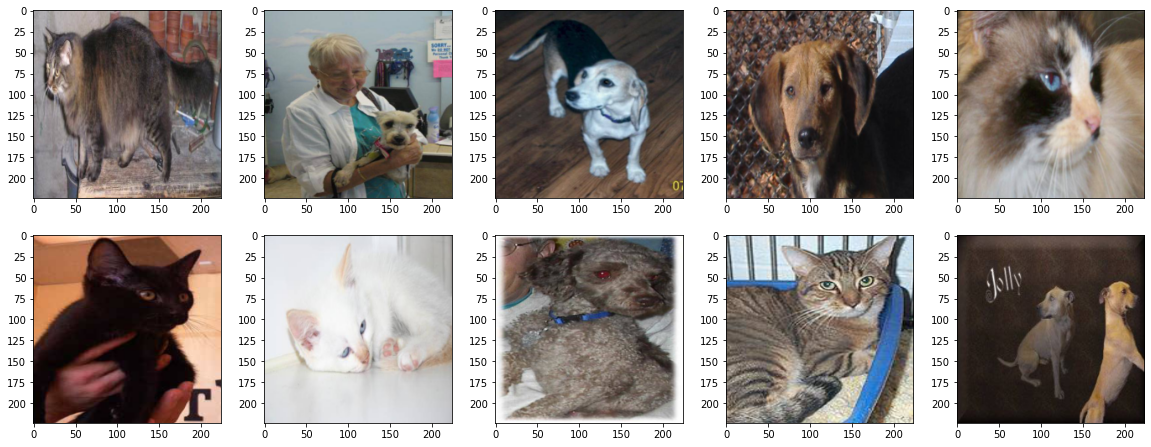

In [41]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize = (20 , 20))
preds = []
for i in range(1 , 11):
  img = X_test[i-1]
  fig.add_subplot( 5 , 5 , i )
  plt.imshow(img.swapaxes(0,2).swapaxes(0 , 1))
plt.show()

In [42]:
y_test[0:11]

tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0])

In [43]:
with torch.no_grad():
  scores = pretrain_model(X_test[0:11].to("cuda")).max(1)

In [44]:
scores[1]

tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')